# Credits

Originally created for a previous version of the [02456-deep-learning](https://github.com/DeepLearningDTU/02456-deep-learning) course material, but [converted to PyTorch](https://github.com/pytorch/tutorials).
See repos for credits.

In [ ]:
## Install pandas if you don't already have it (uncomment line below)

! pip install pandas

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('data_utils.py','wb').write(src)
import data_utils

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the three most used network architectures: FFNs, CNNs and RNNs. It is time to combine these network types into a more advanced model. 
It often happens that you have a combination of data that cannot fully be modeled by any one of these three types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](kaggle.com) that contains several different kinds of data.
First we will download the data and visualize it, and then we will train a network to classify the data.
A simple network with poor performance is provided for you as a starting point, but it is up to you use the things you have learnt to improve the results.


## Kaggle challenge
Kaggle is a website to participate in real life challenges.
Early 2017 it was bought by Google, who wanted access to the global community of data scientists it has created over the last 7 years.
Since then Google has sponsored its expansion and now the prizes of the competitions and the amount of public datasets are bigger than ever. 
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

The challenge we will pursue is the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge.
The dataset consists approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample. We will primarily look into the type of neural network best suited for handling this type of data. 

Lastly, we will train the model and put the outputs in a submission file that we can submit to Kaggle.

# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create a user
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the runtime deconnects. For big files like the kaggle datafolder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data like so:

In [ ]:
!ls drive/'My Drive'

 Andaç			       IE-306.rar
'Colab Notebooks'	       Photo.png
 Dosya_000.jpeg		       SO
'Group 16 peak unithon.pptx'  'Şükrü Han ŞAHİN - ULIP Presentation.pptx'


Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [13]:
drive_path = ''
# local_path = ''  # if you're folder structure is as defined above and you want to run locally

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [14]:
image_paths = glob.glob("images/*.jpg") # if your path to the 
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv('test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint** You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [8]:
# Your code to produce answers here:
print('# of Samples for Testing: {}'.format(test.shape[0]))
print('# of Samples for Training: {}\n'.format(train.shape[0]))

print('Do we have the same information for test and training data?')
diff = set(train.columns.values).symmetric_difference(test.columns.values)
if len(diff)==0:
      print('Answer: Yes.\n')
else:
      print('Answer: No. Some of the features are not valid for both, which are: {}.\n'.format(diff))

# You can uncomment below lines to see the features for each set.
print('Test features:')
print(test.columns.values)
print('Train features:')
print(train.columns.values)        

samples_table = pd.DataFrame(columns=['Name of the Species', '# of Samples'])

species_vec = train.species.unique()
index = 0
for each_species in species_vec:
    new_row = {'Name of the Species': each_species, '# of Samples': len(train[train.species == each_species])}
    samples_table = samples_table.append(new_row, ignore_index=True)
    
display(samples_table)

print('Number of samples per species: {}'.format(samples_table['# of Samples'].mean()))

# of Samples for Testing: 594
# of Samples for Training: 990

Do we have the same information for test and training data?
Answer: No. Some of the features are not valid for both, which are: {'species'}.

Test features:
['id' 'margin1' 'margin2' 'margin3' 'margin4' 'margin5' 'margin6'
 'margin7' 'margin8' 'margin9' 'margin10' 'margin11' 'margin12' 'margin13'
 'margin14' 'margin15' 'margin16' 'margin17' 'margin18' 'margin19'
 'margin20' 'margin21' 'margin22' 'margin23' 'margin24' 'margin25'
 'margin26' 'margin27' 'margin28' 'margin29' 'margin30' 'margin31'
 'margin32' 'margin33' 'margin34' 'margin35' 'margin36' 'margin37'
 'margin38' 'margin39' 'margin40' 'margin41' 'margin42' 'margin43'
 'margin44' 'margin45' 'margin46' 'margin47' 'margin48' 'margin49'
 'margin50' 'margin51' 'margin52' 'margin53' 'margin54' 'margin55'
 'margin56' 'margin57' 'margin58' 'margin59' 'margin60' 'margin61'
 'margin62' 'margin63' 'margin64' 'shape1' 'shape2' 'shape3' 'shape4'
 'shape5' 'shape6' 'shape7' 'shape

,Name of the Species,# of Samples
0,Acer_Opalus,10
1,Pterocarya_Stenoptera,10
2,Quercus_Hartwissiana,10
3,Tilia_Tomentosa,10
4,Quercus_Variabilis,10
...,...,...
94,Ulmus_Bergmanniana,10
95,Quercus_Nigra,10
96,Salix_Intergra,10
97,Quercus_Infectoria_sub,10


Number of samples per species: 10.0


 * **Answer:**

* We have 990 samples in training set and 594 in test set. For training set we have an additional 'species' attribute. There are 99 species in total and 10 samples in each of them.

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discern **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

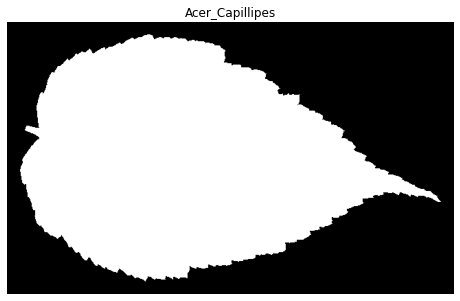

In [24]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its' index in our list of images in order to find the correct image
indexes = [image_paths.index('images\{}.jpg'.format(i)) for i in species_examples]

# Plot of the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

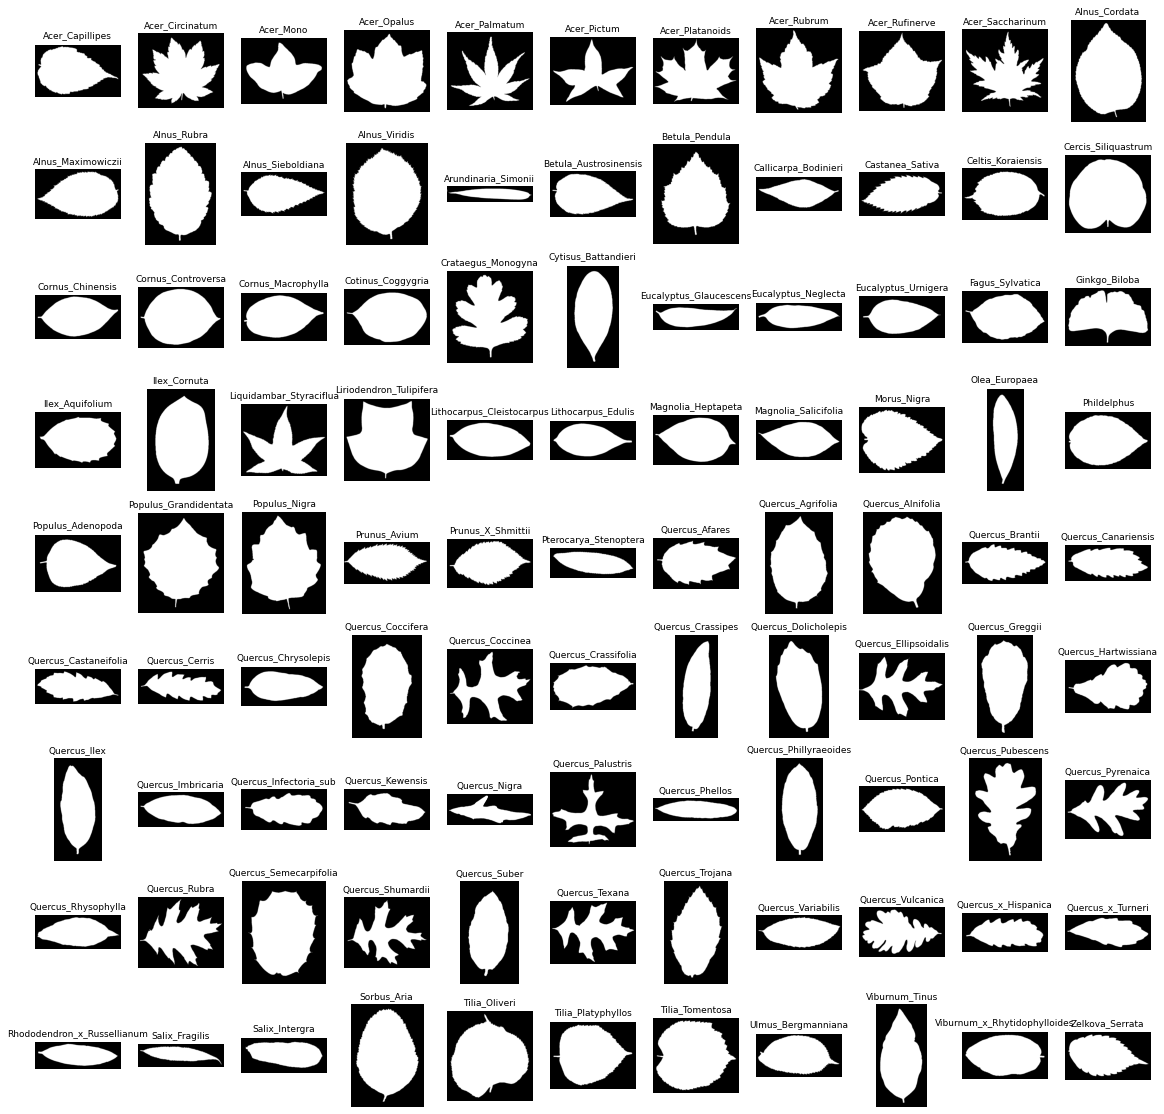

In [25]:
# Now plot 1 image from each category:

index = 0
n_rows = 9 
n_cols = int(len(species_vec)/n_rows)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
for row in range(n_rows):
    for col in range(n_cols):
        image = imread(image_paths[indexes[index]], as_gray=True)
        axes[row][col].imshow(image, cmap='gray')
        axes[row][col].set_title(species[index], fontsize=9)
        axes[row][col].axis('off')
        index += 1

As you can see, classifying leaves is actually a very tough problem.
What makes it even worse, is that we cannot use all the image data we have available.
In order to decrease the amount of computations needed, we need to reduce the size of the images as much as possible.
On top of that our neural network usually only accepts fixed size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its' shape into account seems extremely difficult.

Therefore we will 
- 1) first pad all the images into squares, and
- 2) then resize them, as visualized below:

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is to small should ultimately be determined by an actual test, but what makes visual sense is a good place to start.
Change the `image_size=(?, ?)` parameter below, and note your choice.
 * **Answer:**
- Started with (256, 256) and went low till (12, 12). In the code below, I have chosen (48, 48) to have a differentiation between very close types of leaves. I believe that these sizes are enough to differentiate virtually. I know that computational power is needed, but I believe that I can afford that amount of computational power.

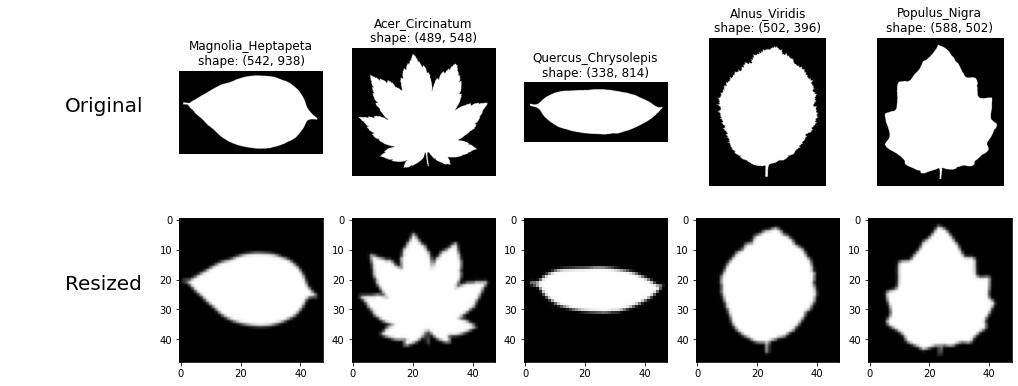

In [26]:
## Image pre-processing
image_size = (48, 48)  # <-- YOUR CODE HERE

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Try to run it a few times to try and get an understanding of how the features differ from species to species.

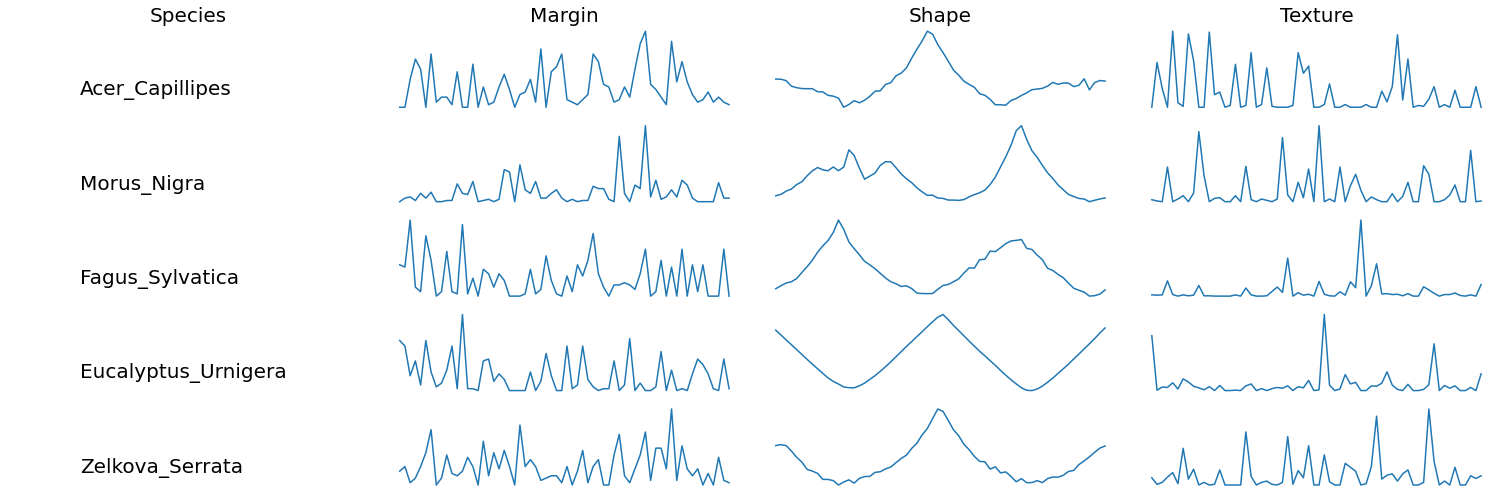

In [27]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 4
So far we have learned about the feed forward neural network (FFNN), the convolutional neural network (CNN) and the recurrent neural network (RNN).

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 * **Answer:**
 - __Image:__ I would use CNN since the convolutional layer and maxpooling structures are better for classifying distinct patterns in images.

 - __Margin and Texture:__ I would normally use FFNN since according to my logic it doesn't need to be keep tracked since it isn't a feature such as shape to be tracked of. It seems that there isn't a need for order or sequece caracteristic for tracking. But when I used RNN for both of these, NN yielded better results. It seems to have a pattern such as in time series data where we need to track the previous values.

 - __Shape:__ I would normally use RNN since according to my logic it needs to be keep tracked since it is the shape feature which has a significant pattern to follow in order to differentiate the leaves. It seems that there a need for order or sequece caracteristic for tracking. But when I used FFNN for this faeture NN yielded better results. Certainly, it has a pattern, but with a simplier neural network for the shape, it yielded better results.

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you going to work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [28]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE =  (image_size[0], image_size[1], 1)  # <-- Your answer here
NUM_CLASSES =  len(species_vec)  # <-- Your answer here == 99

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = margin.shape[1]  # <-- Your answer here == 64

In [29]:
# Paths to data
TRAIN_PATH = drive_path + "train.csv" 
TEST_PATH = drive_path + "test.csv" 
IMAGE_PATHS = glob.glob(drive_path + "images/*.jpg")

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 48, 48, 1)0.280052
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 48, 48, 1)	0.280297
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [32]:
import pickle

# # Dump the data into a pickle file
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

In [70]:
# # Load the data from a pickle file
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

 * **Answer:**

-  _'Batch Size'_ decides how much of the task are we trying to optimize for in one given step.

- Large Batch: Larger batch causes the lack of generalization ability is due to the fact that large batch methods tend to converge to sharp minimizers of the training function.Let’s say we pass the whole data set as one batch, we would reach a sub-optimal minima that decreases the over all loss for all the examples together. We would certainly need a lot of memory for processing this info in one single shot which would lead to a greater time need for model to be trained on a single shot. So higher processing time to make each step in our optimization.

- Small Batch: Smaller batch-size causes in more aggressive/more fluctuations in the gradient direction in comparison to the larger ones. Advantege is that it will process faster than large batch and will take less memory. Better optima would be reached if batches size is decided properly but worse optima would be reached if the batch size is so small.

* There should be a balance set between the larger and smaller batch size which needs some efforts to find.

In [71]:
batch_size = 40
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (40, 48, 48, 1)
	margins, (40, 64)
	shapes, (40, 64)
	textures, (40, 64)
	ts, (40, 99)

VALID
	images, (40, 48, 48, 1)
	margins, (40, 64)
	shapes, (40, 64)
	textures, (40, 64)
	ts, (40, 99)

TEST
	images, (40, 48, 48, 1)
	margins, (40, 64)
	shapes, (40, 64)
	textures, (40, 64)
	ids, 40


# Build the model

In [72]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [73]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions. It might also be useful to look up the helper function for computing convolutional layers' dimensions from lab 4.1. 

In [106]:
height, width, channels = IMAGE_SHAPE

conv_out_channels = 10 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 2       # <-- Padding

conv_out_channels2 = 60
kernel_maxpool = 2
stride_maxpool = 2

# Number of hidden layers for the FFNN. 
num_hidden1=64
num_hidden2=128
num_hidden3=64

# Keep track of features to output layer
# Formula for the output WHERE BOTH THE KERNEL SIZES ARE FIXED AS ABOVE!!!
features_cat_size = int(height*width*channels/(stride_maxpool**2) \
                        /(conv_stride**2)*conv_out_channels2/(stride_maxpool**2)) \
                        + 2*NUM_FEATURES**2 + NUM_FEATURES # <-- Number of features concatenated before output layer

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        # Exercise: Add a recurrent unit like and RNN or GRU
        # >> YOUR CODE HERE <<
        
        self.rnn_1 = nn.GRU(input_size=1, hidden_size=NUM_FEATURES, bias=True, batch_first=True )
        self.rnn_2 = nn.GRU(input_size=1, hidden_size=NUM_FEATURES, bias=True, batch_first=True )

        # ADDING OTHER LAYERS FOR IMPROVEMENTS IN THE NETWORK
        self.max_pool1 = nn.MaxPool2d(kernel_size = kernel_maxpool, stride = stride_maxpool)
        self.drop1 = nn.Dropout2d(p=0.5)
        self.conv_2 = Conv2d(in_channels=conv_out_channels,
                             out_channels=conv_out_channels2,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        self.drop2 = nn.Dropout2d(p=0.5)
        self.max_pool2 = nn.MaxPool2d(kernel_size = kernel_maxpool, stride = stride_maxpool)
        
        self.l1 = nn.Linear(in_features=NUM_FEATURES, out_features=num_hidden1)
        self.l2 = nn.Linear(in_features=num_hidden1, out_features=num_hidden2)
        self.l3 = nn.Linear(in_features=num_hidden2, out_features=num_hidden3)
        
        
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=NUM_CLASSES,
                            bias=True)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        # For "x_image", I used the following architecture before the final linear output layer:
        # Convolutional Layer + Max Pooling + Dropout + Convolutional Layer + Max Pooling + Drop Out 
        
        features_img = x_img.permute(0,3,1,2) # Fit the format into: (N, C, H, W)
        features_img = relu(self.conv_1(features_img))
        features_img = self.max_pool1(features_img)
        features_img = self.drop1(features_img)
        features_img = relu(self.conv_2(features_img))
        features_img = self.max_pool2(features_img)
        features_img = self.drop2(features_img)
        
        # Change dimensions of the features by serializing them all to be used in the final layer.
        features_img = features_img.view(-1, int(height*width*channels/(stride_maxpool**2)\
                                                 /(conv_stride**2)*conv_out_channels2/(stride_maxpool**2)))
    
        # Append features to the list "features"
        features.append(features_img)
        
        
        ## Use concatenated leaf features for FFNN ##
        # >> YOUR CODE HERE <<
        # x = torch.cat((x_margin, x_texture), dim=1)  # if you want to use features as feature vectors

        # I modelled "x_shape" in a pure FFNN architecture: 
        # The following is a 3 Nonlinear Hidden Layers and the output is used in the final Linear Output layer.
        x_shape = relu(self.l1(x_shape))
        x_shape = relu(self.l2(x_shape))
        x_shape = relu(self.l3(x_shape))
        features_vector = x_shape.view(-1,num_hidden3) # Serialize the output to be used in linear final output layer.
        
        # Append features to the list "features"
        features.append(features_vector)
        
        
        
        
        ## Use concatenated leaf features for RNN ##
        # - Chage dimensions to fit GRU
        # - Apply GRU
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        # I decided to use two separate Recurrent Layers for "x_margin" and "x_texture".
    
        x_margin = x_margin.view(-1, NUM_FEATURES,1) # Serialize before recurrent
        x_texture = x_texture.view(-1, NUM_FEATURES,1) # Serialize before recurrent
        
        x_margin, hidden1 = self.rnn_1(x_margin) #  Recurrent Layer for Margin
        x_margin = x_margin.contiguous().view(-1,NUM_FEATURES**2) # Serialize 
        
        # Append features to the list "features"
        features.append(x_margin)
        
        x_texture,hidden2 = self.rnn_2(x_texture) # Recurrent Layer for texture
        x_texture=x_texture.contiguous().view(-1,NUM_FEATURES**2) # Serialize
        
        # Append features to the list "features"
        features.append(x_texture)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)      
        
        out['out'] = self.l_out(features_final)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (rnn_1): GRU(1, 64, batch_first=True)
  (rnn_2): GRU(1, 64, batch_first=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.5, inplace=False)
  (conv_2): Conv2d(10, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (drop2): Dropout2d(p=0.5, inplace=False)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=64, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l_out): Linear(in_features=16896, out_features=99, bias=True)
)


# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [107]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss() #<-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [108]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[ 0.2420,  0.2091, -0.3191,  ...,  0.0301, -0.3195,  0.0920],
        [-0.1498,  0.2908, -0.1665,  ...,  0.0370, -0.3042,  0.6295],
        [-0.0824, -0.0827,  0.0082,  ..., -0.4727, -0.4313,  0.3582],
        ...,
        [-0.3667, -0.3684,  0.0905,  ..., -0.1020, -0.1895, -0.2246],
        [-0.3349,  0.1093, -0.4965,  ...,  0.2718, -0.8390,  0.4176],
        [ 0.3806,  0.2990, -0.3326,  ..., -0.3153, -0.0749,  0.5747]],
       grad_fn=<AddmmBackward>)

# Train

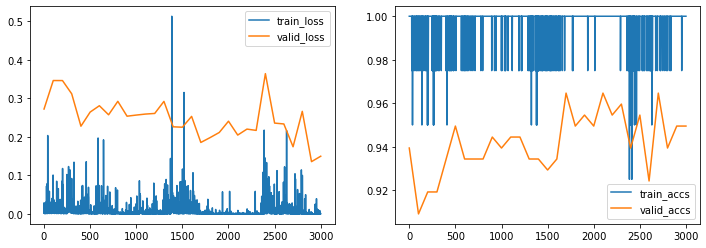

In [112]:
# Setup settings for training 
VALIDATION_SIZE = 0.2 # 0.1 is ~ 100 samples for validation
max_iter = 3000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
#         print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

In [113]:
valid_accs

[array(0.93939394, dtype=float32),
 array(0.90909094, dtype=float32),
 array(0.9191919, dtype=float32),
 array(0.9191919, dtype=float32),
 array(0.93434346, dtype=float32),
 array(0.94949496, dtype=float32),
 array(0.93434346, dtype=float32),
 array(0.93434346, dtype=float32),
 array(0.93434346, dtype=float32),
 array(0.9444444, dtype=float32),
 array(0.93939394, dtype=float32),
 array(0.9444444, dtype=float32),
 array(0.9444444, dtype=float32),
 array(0.93434346, dtype=float32),
 array(0.93434346, dtype=float32),
 array(0.9292929, dtype=float32),
 array(0.93434346, dtype=float32),
 array(0.96464646, dtype=float32),
 array(0.94949496, dtype=float32),
 array(0.95454544, dtype=float32),
 array(0.94949496, dtype=float32),
 array(0.96464646, dtype=float32),
 array(0.95454544, dtype=float32),
 array(0.959596, dtype=float32),
 array(0.93939394, dtype=float32),
 array(0.95454544, dtype=float32),
 array(0.92424244, dtype=float32),
 array(0.96464646, dtype=float32),
 array(0.93939394, dtype=flo

In [114]:
valid_loss

[array(0.27237496, dtype=float32),
 array(0.34643754, dtype=float32),
 array(0.346344, dtype=float32),
 array(0.31196404, dtype=float32),
 array(0.22783607, dtype=float32),
 array(0.26452133, dtype=float32),
 array(0.2810069, dtype=float32),
 array(0.25748676, dtype=float32),
 array(0.2924266, dtype=float32),
 array(0.25381744, dtype=float32),
 array(0.25673348, dtype=float32),
 array(0.2593519, dtype=float32),
 array(0.26095366, dtype=float32),
 array(0.29228476, dtype=float32),
 array(0.22623463, dtype=float32),
 array(0.2252009, dtype=float32),
 array(0.25334296, dtype=float32),
 array(0.18563803, dtype=float32),
 array(0.1981741, dtype=float32),
 array(0.21155332, dtype=float32),
 array(0.24081656, dtype=float32),
 array(0.20480783, dtype=float32),
 array(0.2202999, dtype=float32),
 array(0.21693301, dtype=float32),
 array(0.36434874, dtype=float32),
 array(0.2359103, dtype=float32),
 array(0.23364677, dtype=float32),
 array(0.17443064, dtype=float32),
 array(0.2664079, dtype=float

## Exercise 9

**Tip** This is very small dataset (number of observations) compared to the number of features.
This means that overfitting will likely be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start out simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred, you can change learning rate, try testing various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you of to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batchnormalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you cant. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of final architecture
* Description of training parameters
* Description of final results (Kaggle and validation)

**Answer:**

- NN is improved with via adding additional layers or subtracting excessive layers. I tried different batch sizes to overcome under and over fitting (I tried 200, 100, 80, 40, 20). I used batch normalization but didn't get better results. I played with image parameters such as size and convolutional layers. Since the computational power is limited, I cut it off at some point. Finally, I changed the regularization term, learning rate, training iteration as well. But overall, I can say that, best result I can get is above. Of course better results would have been obtained with a better parameter tuning and combination of different NN for each inpu type. I need more computational power to have a better parameter tuning oppurtunities.

- For the final architecture; 
    - __image__: 3 convolutional layer were making it worse so I decided in 2 and added max pooling and dropout. 
    - __texture & margin__: At first I guessed that these two would have resulted better with FFNN but for the same parameter inputs, I got better result when these two are trained with RNN and __shape__ with FFNN.  As a result, I craeted 2 independent Recursive layer for each and their outputs are appended.
    - __shape__: At first I trained NN while __shape__ was RNN since it needs a track of previous series but the result were worse. Then, FFNN which has 3 hidden layers worked better. 


#### For training:

Batch size is 40 and Neural Network is trained with 3000 maximum iteration.
Adam Optimizer with learning rate 0.001 using cross-entropy loss.


My latest scores are as follows;

Validation accuracy:  ~0.95,

Validation loss:  ~0.15,

Kaggle Score:  ~0.20.


- My Kaggle Username is: https://www.kaggle.com/sukruhansahin 
- You can check my submission.

# Submission to Kaggle

First we have to make testset predictions, then we have to place it in the submission file and the upload to Kaggle for our score! You can upload at max 5 submissions a day.

In [115]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

## Make submission file

In [116]:
# Used softmax on prediction probabilities for Kaggle to interpret the results better.
preds_df = pd.DataFrame(softmax(torch.Tensor(preds_test), dim=1).numpy(),  columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(drive_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,1.559302e-09,1.105141e-10,6.661089e-14,1.984357e-05,5.448740e-13,7.633103e-14,9.094256e-13,1.570753e-09,2.225444e-10,...,8.377138e-14,5.227424e-13,3.690848e-13,5.256983e-12,5.123627e-10,1.665441e-12,7.469530e-15,2.245656e-07,8.011943e-18,5.524249e-14
1,7,3.056483e-08,2.078568e-08,8.085046e-07,3.896611e-07,7.444029e-10,1.266051e-10,3.408141e-08,1.903331e-08,2.056586e-09,...,1.005243e-11,7.091744e-06,5.918250e-16,4.782943e-10,4.748212e-10,4.858488e-09,6.055330e-08,7.086926e-11,8.928082e-10,4.329355e-04
2,9,1.329319e-13,9.999521e-01,2.078366e-12,1.520601e-07,2.846700e-06,5.532629e-10,2.826916e-07,5.389070e-09,1.225947e-08,...,4.111387e-12,1.021112e-12,1.896877e-12,2.112907e-13,4.381546e-11,2.699281e-09,9.253760e-09,2.865682e-19,1.253659e-11,3.286645e-14
3,12,3.439553e-17,3.771126e-12,3.476452e-15,7.275682e-15,5.314542e-15,2.807497e-16,8.188610e-14,5.630220e-14,2.908395e-10,...,8.454697e-15,2.269520e-13,1.417040e-15,3.034120e-18,7.602370e-15,1.366105e-16,2.707914e-10,6.250014e-21,1.539418e-12,4.775010e-13
4,13,7.083751e-19,3.654016e-13,4.683927e-21,6.479830e-15,3.882125e-18,3.891244e-18,2.543641e-17,2.495947e-17,9.247981e-19,...,1.332553e-17,1.592957e-21,1.008814e-11,5.703227e-14,2.515264e-09,1.154452e-11,3.320408e-13,4.797295e-19,2.410753e-17,4.737750e-20


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 